<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.0.0


'cpu'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

However, to prevent underperforming of the model you can:
- Add more layers/hidden units to your model: It can be that the model doesn't have enough capability to lern the required parameters. To add more predictive power to your model, it is possible to increase the number of hidden layers/units within those layers.
- Transfer Learning: Use the patterns from a already working, similar, model and adjust them to the one you're developing.
- Less regularization: Trying to prevent overfitting with regularization, might transform the overfitting in an underfitting problem. Relaxing the regularization can help the model to fit the data better.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [6]:
# Setup train and testing paths
train_path = image_path / "train"
test_path = image_path / "test"

train_path, test_path

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512
Image width: 512


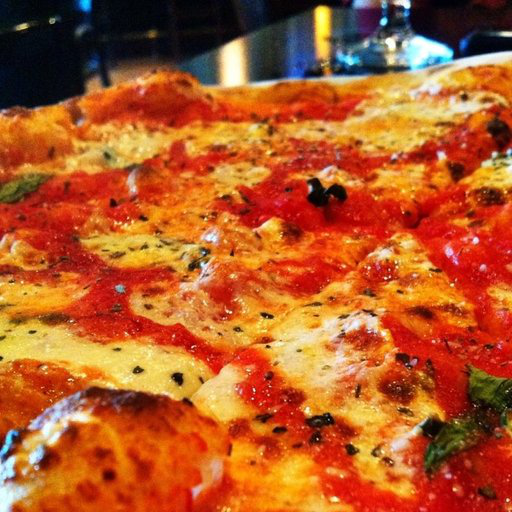

In [7]:
# Visualize an image
import random
from PIL import Image

# Set the seed
random.seed(42) 

# 1. Get all image paths (* means "all_combinations")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

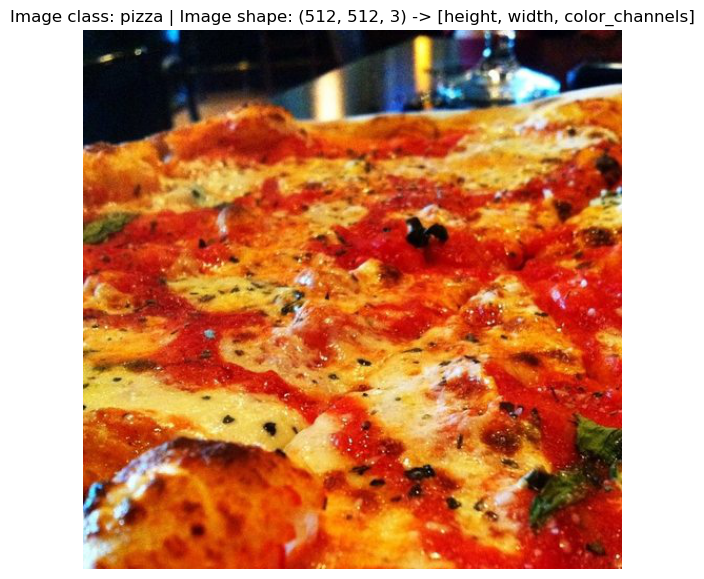

In [8]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [9]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

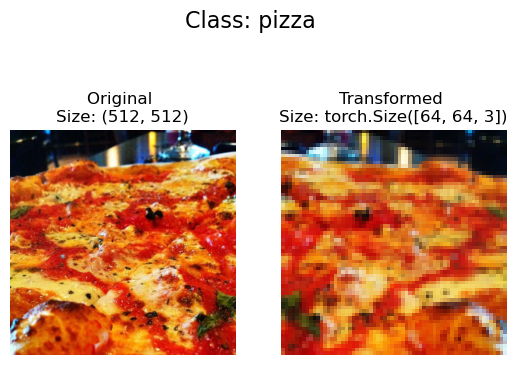

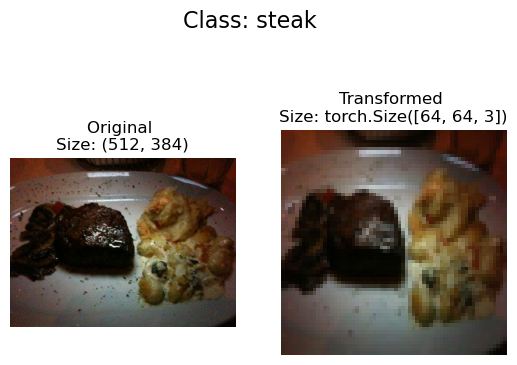

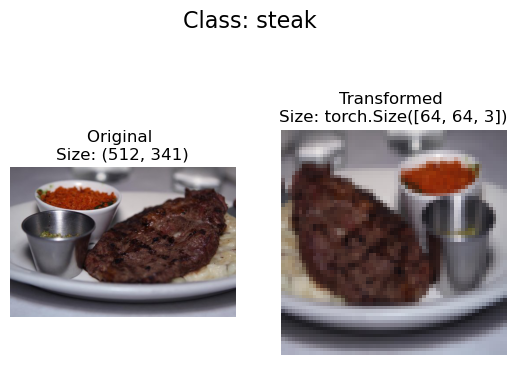

In [11]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Plot the transformation
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

### Load image data using `ImageFolder`

In [15]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_path,
                                  transform=data_transform)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [16]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [28]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,    # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

Creating DataLoader's with batch size 32 and 4 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7fe3afcbffd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe3b07f55e0>)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [29]:
# How many batches of images are in our data loaders?
print(len(train_dataloader), len(test_dataloader))

8 3


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [32]:
# Model_0: TinyVGG
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                        out_channels=hidden_units,
                        kernel_size=3,
                        stride=1,
                        padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                        out_channels=hidden_units,
                        kernel_size=3,
                        stride=1,
                        padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)    # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                        out_channels=hidden_units,
                        kernel_size=3,
                        padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                        out_channels=hidden_units,
                        kernel_size=3,
                        padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)    # default stride value is same as kernel_size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                        out_features=output_shape)
        )
    def forward(self, x:torch.Tensor):
       x = self.conv_block_1(x)
       x = self.conv_block_2(x)
       x = self.classifier(x)
       return x

In [33]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,    # number of color channels (3 for RGB) 
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [34]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 4. Create training and testing functions for `model_0`.

In [36]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    y_pred = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item() 

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [37]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    
  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [38]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [41]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

# Set number of epochs
NUM_EPOCHS = 5

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0975 | train_acc: 0.2891 | test_loss: 1.1040 | test_acc: 0.1875
Epoch: 2 | train_loss: 1.0972 | train_acc: 0.4062 | test_loss: 1.1041 | test_acc: 0.1771
Epoch: 3 | train_loss: 1.0975 | train_acc: 0.4180 | test_loss: 1.1040 | test_acc: 0.2083
Epoch: 4 | train_loss: 1.0975 | train_acc: 0.3711 | test_loss: 1.1040 | test_acc: 0.1875
Epoch: 5 | train_loss: 1.0973 | train_acc: 0.2656 | test_loss: 1.1040 | test_acc: 0.1875
Total training time: 268.647 seconds


In [42]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

# Set number of epochs
NUM_EPOCHS = 20

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2695 | test_loss: 1.1381 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0827 | train_acc: 0.4258 | test_loss: 1.1684 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1202 | train_acc: 0.2930 | test_loss: 1.1729 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0938 | train_acc: 0.4141 | test_loss: 1.1403 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0949 | train_acc: 0.2930 | test_loss: 1.1412 | test_acc: 0.2188
Epoch: 6 | train_loss: 1.0916 | train_acc: 0.3750 | test_loss: 1.1473 | test_acc: 0.2917
Epoch: 7 | train_loss: 1.0961 | train_acc: 0.4258 | test_loss: 1.1154 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.0382 | train_acc: 0.4922 | test_loss: 1.0553 | test_acc: 0.5559
Epoch: 9 | train_loss: 0.9636 | train_acc: 0.6328 | test_loss: 1.0207 | test_acc: 0.5350
Epoch: 10 | train_loss: 0.9224 | train_acc: 0.4883 | test_loss: 1.0448 | test_acc: 0.5559
Epoch: 11 | train_loss: 0.8783 | train_acc: 0.6484 | test_loss: 0.9989 | test_acc: 0.4328
Epoch: 12 | train_l

In [43]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

# Set number of epochs
NUM_EPOCHS = 50

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2695 | test_loss: 1.1381 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0827 | train_acc: 0.4258 | test_loss: 1.1684 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1202 | train_acc: 0.2930 | test_loss: 1.1729 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0938 | train_acc: 0.4141 | test_loss: 1.1403 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0949 | train_acc: 0.2930 | test_loss: 1.1412 | test_acc: 0.2188
Epoch: 6 | train_loss: 1.0916 | train_acc: 0.3750 | test_loss: 1.1473 | test_acc: 0.2917
Epoch: 7 | train_loss: 1.0961 | train_acc: 0.4258 | test_loss: 1.1154 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.0382 | train_acc: 0.4922 | test_loss: 1.0553 | test_acc: 0.5559
Epoch: 9 | train_loss: 0.9636 | train_acc: 0.6328 | test_loss: 1.0207 | test_acc: 0.5350
Epoch: 10 | train_loss: 0.9224 | train_acc: 0.4883 | test_loss: 1.0448 | test_acc: 0.5559
Epoch: 11 | train_loss: 0.8783 | train_acc: 0.6484 | test_loss: 0.9989 | test_acc: 0.4328
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [44]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Recreate an instance of TinyVGG
model_1 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=20, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                             lr=0.001)

# Set number of epochs
NUM_EPOCHS = 20

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1043 | train_acc: 0.4258 | test_loss: 1.1059 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1215 | train_acc: 0.3047 | test_loss: 1.0985 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0932 | train_acc: 0.3906 | test_loss: 1.1022 | test_acc: 0.2188
Epoch: 4 | train_loss: 1.0922 | train_acc: 0.4180 | test_loss: 1.0757 | test_acc: 0.5256
Epoch: 5 | train_loss: 1.0910 | train_acc: 0.4062 | test_loss: 1.0689 | test_acc: 0.3125
Epoch: 6 | train_loss: 1.0524 | train_acc: 0.4688 | test_loss: 1.0750 | test_acc: 0.4138
Epoch: 7 | train_loss: 0.9539 | train_acc: 0.6016 | test_loss: 1.1309 | test_acc: 0.3229
Epoch: 8 | train_loss: 0.8908 | train_acc: 0.5859 | test_loss: 0.9791 | test_acc: 0.4337
Epoch: 9 | train_loss: 0.9418 | train_acc: 0.4727 | test_loss: 1.0126 | test_acc: 0.4972
Epoch: 10 | train_loss: 0.8571 | train_acc: 0.4805 | test_loss: 1.0694 | test_acc: 0.3911
Epoch: 11 | train_loss: 0.8449 | train_acc: 0.6094 | test_loss: 1.0497 | test_acc: 0.3826
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [45]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [46]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.


Excellent, we now have double the training and testing images... 

In [47]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [48]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

# Create datasets
train_dataset_20_percent = datasets.ImageFolder(train_data_20_percent_path, simple_transform)
test_dataset_20_percent = datasets.ImageFolder(test_data_20_percent_path, simple_transform)

# Create dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_20_percent = DataLoader(dataset=train_dataset_20_percent,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         num_workers=NUM_WORKERS)
test_dataloader_20_percent = DataLoader(dataset=test_dataset_20_percent,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=NUM_WORKERS)
train_dataloader_20_percent, test_dataloader_20_percent

(<torch.utils.data.dataloader.DataLoader at 0x7fe3b07e5ee0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe3b08401f0>)

In [49]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), 
                             lr=0.001)

model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader_20_percent,
                        test_dataloader=test_dataloader_20_percent,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1043 | train_acc: 0.3333 | test_loss: 1.1009 | test_acc: 0.2875
Epoch: 2 | train_loss: 1.0883 | train_acc: 0.3521 | test_loss: 1.0806 | test_acc: 0.3000
Epoch: 3 | train_loss: 1.0426 | train_acc: 0.3958 | test_loss: 0.9939 | test_acc: 0.4244
Epoch: 4 | train_loss: 0.9189 | train_acc: 0.5458 | test_loss: 0.9227 | test_acc: 0.5585
Epoch: 5 | train_loss: 0.8754 | train_acc: 0.6146 | test_loss: 0.9362 | test_acc: 0.5023


## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [60]:
image_address = "https://www.revistamasviajes.com/wp-content/uploads/2020/03/suchi-plato-palitos-chinos-.jpg"

In [62]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "sushi-image.jpg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get(image_address)
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [63]:
import torchvision

# Read in custom image and convert it into float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.1647, 0.1647, 0.1686,  ..., 0.2902, 0.2941, 0.3176],
         [0.1647, 0.1647, 0.1647,  ..., 0.2941, 0.3725, 0.3804],
         [0.1608, 0.1608, 0.1608,  ..., 0.3294, 0.3961, 0.3490],
         ...,
         [0.4235, 0.4314, 0.4353,  ..., 0.2275, 0.2275, 0.2314],
         [0.4314, 0.4392, 0.4392,  ..., 0.2275, 0.2275, 0.2275],
         [0.4392, 0.4431, 0.4431,  ..., 0.2275, 0.2275, 0.2275]],

        [[0.1765, 0.1765, 0.1804,  ..., 0.4078, 0.4000, 0.4235],
         [0.1765, 0.1765, 0.1765,  ..., 0.4118, 0.4784, 0.4863],
         [0.1725, 0.1725, 0.1725,  ..., 0.4471, 0.5020, 0.4549],
         ...,
         [0.4431, 0.4510, 0.4549,  ..., 0.2314, 0.2314, 0.2353],
         [0.4510, 0.4588, 0.4588,  ..., 0.2314, 0.2314, 0.2314],
         [0.4588, 0.4627, 0.4627,  ..., 0.2314, 0.2314, 0.2314]],

        [[0.1961, 0.1961, 0.2000,  ..., 0.1255, 0.1216, 0.1451],
         [0.1961, 0.1961, 0.1961,  ..., 0.1373, 0.2078, 0.2157],
         [0.1922, 0.1922, 0.1922,  ..

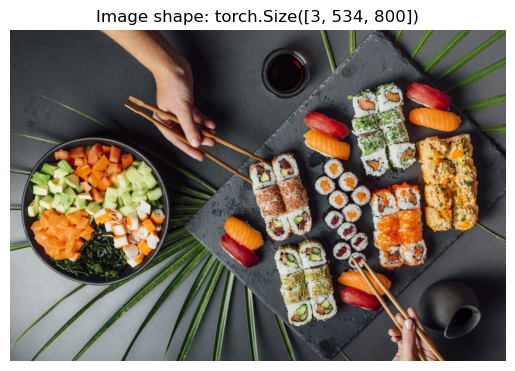

In [73]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [65]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 534, 800])
New shape: torch.Size([3, 64, 64])


/Users/ggomezji/miniconda3/envs/torch/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


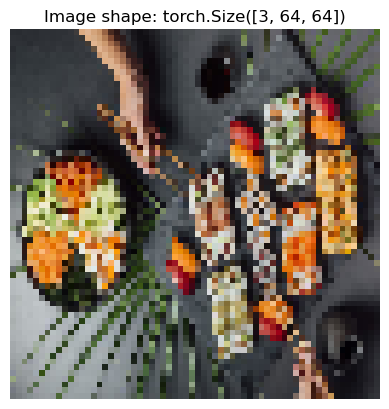

In [67]:
# Plot transformed image
plt.imshow(custom_image_transformed.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image_transformed.shape}")
plt.axis(False);

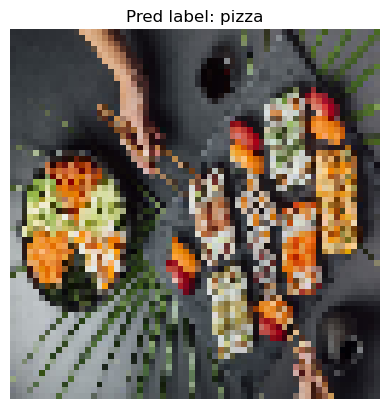

In [87]:
model_2.eval()
with torch.inference_mode():
    # Turn image in single batch and pass to target device
    batch = custom_image_transformed.unsqueeze(0).to(device)

    # Predict on image
    y_pred_logit = model_1(batch)

    # Convert pred_logit to pred_label
    pred_label = torch.argmax(y_pred_logit, dim=1)

# Plot the image and prediction
plt.imshow(custom_image_transformed.permute(1, 2, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False);

* The model is not performing correctly.
We see that the test accuracay is 50% which means that the predictions are being made randomly.
Also, the test loss is ~90% which is considerably high.
I decided to increase the number of epochs from 5 to 20 to see if the model improves but I will have to do further analysis because there's no improvement changing the number of neurons.

In [88]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), 
                             lr=0.001)

model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader_20_percent,
                        test_dataloader=test_dataloader_20_percent,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1043 | train_acc: 0.3333 | test_loss: 1.1009 | test_acc: 0.2875
Epoch: 2 | train_loss: 1.0883 | train_acc: 0.3521 | test_loss: 1.0806 | test_acc: 0.3000
Epoch: 3 | train_loss: 1.0426 | train_acc: 0.3958 | test_loss: 0.9939 | test_acc: 0.4244
Epoch: 4 | train_loss: 0.9189 | train_acc: 0.5458 | test_loss: 0.9227 | test_acc: 0.5585
Epoch: 5 | train_loss: 0.8754 | train_acc: 0.6146 | test_loss: 0.9362 | test_acc: 0.5023
Epoch: 6 | train_loss: 0.8192 | train_acc: 0.6562 | test_loss: 1.0133 | test_acc: 0.4835
Epoch: 7 | train_loss: 0.8689 | train_acc: 0.6021 | test_loss: 0.8683 | test_acc: 0.5693
Epoch: 8 | train_loss: 0.7617 | train_acc: 0.6792 | test_loss: 0.8555 | test_acc: 0.6290
Epoch: 9 | train_loss: 0.7667 | train_acc: 0.6771 | test_loss: 0.9041 | test_acc: 0.5426
Epoch: 10 | train_loss: 0.7711 | train_acc: 0.6604 | test_loss: 0.9144 | test_acc: 0.5977
Epoch: 11 | train_loss: 0.7060 | train_acc: 0.6854 | test_loss: 0.8752 | test_acc: 0.6631
Epoch: 12 | train_l